In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "sisi"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from Utils.data_utils import load_train_test_data_eu
from matplotlib import pyplot as plt
from pandas import Timestamp
import time
import pickle
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [8]:
(train_list, test_list), country_list = load_train_test_data_eu(pwd)

In [9]:
#Creating lag value for each state '''probably not needed'''
for i in range(len(train_list)):
    train_list[i]['lag1'] = train_list[i]['carbon_per_MWh'].shift(24)
    train_list[i] = train_list[i].dropna()
    
for i in range(len(test_list)):
    test_list[i]['lag1'] = test_list[i]['carbon_per_MWh'].shift(24)
    test_list[i] = test_list[i].dropna()

In [11]:
def chunks(list_in, n):
    for i in range(0, len(list_in), n):
        yield list_in[i:i+n]

In [12]:
test_splitted_list = []
for i in range(len(test_list)):
    test_splitted_list.append(list(chunks(test_list[i], 168)))

In [10]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [28]:
merged_predictions = []
merged_errors = []
for train, test_splitted in zip(train_list, test_splitted_list):
    predictions = []
    errors = []
    train_features = np.array(train['lag1'])
    train_labels = np.array(train['carbon_per_MWh'])
    for i,test in enumerate(test_splitted):
        start = time.time()
        test_features = np.array(test['lag1'])
        test_labels = np.array(test['carbon_per_MWh'])
        rf.fit(train_features.reshape(-1,1), train_labels)
        prediction = rf.predict(test_features.reshape(-1,1))
        predictions.append(prediction)
        errors.append(abs(prediction - test_labels))
        train_features = np.hstack((train_features, test_features))
        train_labels = np.hstack((train_labels, test_labels))
        end = time.time()
        print(f"Iter {i+1} done. Time: {(end-start):.2f}")
    merged_predictions.append(predictions)
    merged_errors.append(errors)

Iter 1 done. Time: 16.43
Iter 2 done. Time: 16.45
Iter 3 done. Time: 16.49
Iter 4 done. Time: 16.82
Iter 5 done. Time: 17.23
Iter 6 done. Time: 16.92
Iter 7 done. Time: 17.31
Iter 8 done. Time: 17.14
Iter 9 done. Time: 17.55
Iter 10 done. Time: 17.39
Iter 11 done. Time: 17.68
Iter 12 done. Time: 18.28
Iter 13 done. Time: 18.24
Iter 14 done. Time: 18.00
Iter 15 done. Time: 18.05
Iter 16 done. Time: 18.14
Iter 17 done. Time: 18.42
Iter 18 done. Time: 18.50
Iter 19 done. Time: 18.63
Iter 20 done. Time: 18.56
Iter 1 done. Time: 16.99
Iter 2 done. Time: 17.17
Iter 3 done. Time: 17.56
Iter 4 done. Time: 17.77
Iter 5 done. Time: 17.93
Iter 6 done. Time: 18.34
Iter 7 done. Time: 18.27
Iter 8 done. Time: 18.48
Iter 9 done. Time: 18.39
Iter 10 done. Time: 18.51
Iter 11 done. Time: 18.68
Iter 12 done. Time: 19.28
Iter 13 done. Time: 19.78
Iter 14 done. Time: 19.56
Iter 15 done. Time: 19.74
Iter 16 done. Time: 20.09
Iter 17 done. Time: 20.04
Iter 18 done. Time: 20.01
Iter 19 done. Time: 20.40
Iter

In [29]:
for state, error in zip(country_list, merged_errors):
    print(f"MAE for {state} = {np.mean(error)}")

ValueError: operands could not be broadcast together with shapes (168,) (14,) 

In [53]:
err = [merged_errors[i] for i in range(len(merged_errors[i]))]

IndexError: list index out of range

In [58]:
for state, errors in zip(country_list, merged_errors):
    error_all = []
    for i in range(len(errors)):
        error_all.extend(list(errors[i]))
    print(f"MAE for {state} = {np.mean(error_all)}")

MAE for FI = 30.675096437498826
MAE for ES = 34.562674964889986
MAE for IT = 36.45678648670606
MAE for DK = 107.17786764855155
MAE for PL = 79.49699033263578
MAE for FR = 12.15166586539757
MAE for SE = 0.014897020868864895
MAE for CZ = 32.940116813717275
MAE for CH = 0.0


In [59]:
predictions = []
for prediction in merged_predictions:
    temp = []
    for i in range(len(prediction)):
        temp.extend(list(prediction[i]))
    predictions.append(temp)

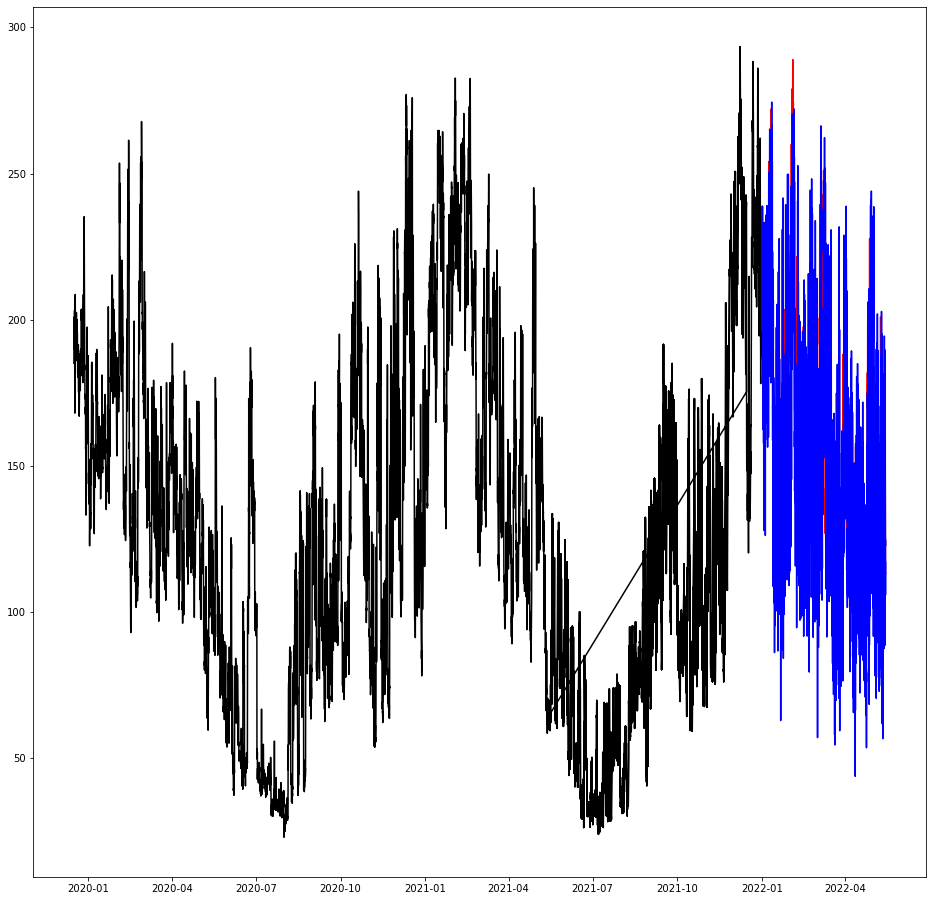

In [65]:
plt.figure(figsize=(16,16))
plt.plot(train_list[0].index, train_list[0]['carbon_per_MWh'], color='black')
plt.plot(test_list[0].index, test_list[0]['carbon_per_MWh'], color='red')
plt.plot(test_list[0].index, predictions[0], color='blue')

In [69]:
hour_dict_list = []
for i in range(len(test_list)):
    hour_dict = {test_list[i].index[j] : predictions[i][j] for j in range(len(predictions[i]))}
    hour_dict_list.append(hour_dict)

In [70]:
hour_dict_list[0]

{Timestamp('2022-01-01 01:00:00+0000', tz='UTC'): 238.75977455827348,
 Timestamp('2022-01-01 02:00:00+0000', tz='UTC'): 195.69591049184635,
 Timestamp('2022-01-01 03:00:00+0000', tz='UTC'): 221.5332980974508,
 Timestamp('2022-01-01 04:00:00+0000', tz='UTC'): 209.77833436026125,
 Timestamp('2022-01-01 05:00:00+0000', tz='UTC'): 238.7854864048267,
 Timestamp('2022-01-01 06:00:00+0000', tz='UTC'): 196.68392446398948,
 Timestamp('2022-01-01 07:00:00+0000', tz='UTC'): 228.7145220365352,
 Timestamp('2022-01-01 08:00:00+0000', tz='UTC'): 233.2474531912653,
 Timestamp('2022-01-01 09:00:00+0000', tz='UTC'): 218.0910743197518,
 Timestamp('2022-01-01 10:00:00+0000', tz='UTC'): 225.99348042503325,
 Timestamp('2022-01-01 11:00:00+0000', tz='UTC'): 216.41490400744524,
 Timestamp('2022-01-01 12:00:00+0000', tz='UTC'): 207.98887919838535,
 Timestamp('2022-01-01 13:00:00+0000', tz='UTC'): 217.3835043125681,
 Timestamp('2022-01-01 14:00:00+0000', tz='UTC'): 228.53150305135514,
 Timestamp('2022-01-01 15: